## Laboratorio di Potenziamento 1 Giugno 2023

## Esercizio 1
Si consideri il sistema lineare Ax=b, con A matrice e b termine noto memorizzati nel file ``testE.mat``.  La soluzione esatta del problema è il vettore x=[1,1,1,...1].Risolvere il sistema utilizzando i diversi metodi adatti visti a lezione adatti per risolverlo ed individuare il metodo più efficiente. Commentare i risultati ottenuti  giustificandoli alla luce della teoria. 

Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('testE.mat')``

``A=dati["A"] ``

`` b=dati["b"] ``

In [155]:
from scipy.io import loadmat
import numpy as np
import scipy.linalg as spl
import RisolviSis as RS
import matplotlib.pyplot as plt
dati = loadmat('testE.mat')

In [156]:
A=dati["A"] 
b=dati["b"]

In [157]:
# per capire se m è maggiore di n: nel caso sarebbe sovradeterminata e procedi con le soluzioni relative
n,m=A.shape
print("Dimensione di A",n,m)

Dimensione di A 100 100


In [158]:
# se più del 33% degli elementi è diversa da 0 allora è densa
nz=np.count_nonzero(A)/(n*m)
perc_nz=nz*100
print("Percentuale elementi diversi da zero ",perc_nz,"%")

Percentuale elementi diversi da zero  2.98 %


In [159]:
flag=A==A.T
if np.all(flag)==0:
    print("La matrice non è simmetrica")
else:
    print("La matrice è simmetrica")

if(flag.all()):
    print("definita positiva")
else:
    print("no")
   

La matrice non è simmetrica
no


Verifico se è a diagonale dominante-
ATTENZIONE: Verifico che la matrice sia a **diagonale dominante** (non strettamente dominante), cioè tale abs(elemento diagonale)>=sum_abs(extradiag): In questo caso i metodi convergono, ma molto lentamente perchè come si può vedere il raggio spettrale è molto vicino ad 1, quindi si ha ancora convergenza, ma lenta.

In [160]:
def verifica_dd(A):
    n=A.shape[0]
    flag=True
    for i in range(n):
       el_diag=np.abs(A[i,i])
       print("elemento diagonale:", el_diag)
       # tutte le righe - elementi diagonali
       # diagonale dominante: A è diagonale dominante se il valore 
       # assoluto del elemento sulla diagonale è >= della sommatoria 
       # in valore invalore assoluto dei restanti valori sulla riga
       sum_extradiag=np.sum(np.abs(A[i,:]))-np.abs(A[i,i])
       if el_diag< sum_extradiag:
            print("Matrice non a diagonale  dominante")
            flag=False
            return flag
        
    return flag
                  
                              

In [161]:
dd=verifica_dd(A)
print("Matrice a diagonale dominante? ",dd)
 

elemento diagonale: 2089.7
elemento diagonale: 2088.7
elemento diagonale: 2087.7
elemento diagonale: 2086.7
elemento diagonale: 2085.7
elemento diagonale: 2084.7
elemento diagonale: 2083.7
elemento diagonale: 2082.7
elemento diagonale: 2081.7
elemento diagonale: 2080.7
elemento diagonale: 2079.7
elemento diagonale: 2078.7
elemento diagonale: 2077.7
elemento diagonale: 2076.7
elemento diagonale: 2075.7
elemento diagonale: 2074.7
elemento diagonale: 2073.7
elemento diagonale: 2072.7
elemento diagonale: 2071.7
elemento diagonale: 2070.7
elemento diagonale: 2069.7000000000003
elemento diagonale: 2068.7000000000003
elemento diagonale: 2067.7
elemento diagonale: 2066.7
elemento diagonale: 2065.7
elemento diagonale: 2064.7
elemento diagonale: 2063.7
elemento diagonale: 2062.7
elemento diagonale: 2061.7000000000003
elemento diagonale: 2060.7
elemento diagonale: 2059.7
elemento diagonale: 2058.7
elemento diagonale: 2057.7
elemento diagonale: 2056.7
elemento diagonale: 2055.7
elemento diagonale:

In [162]:
def jacobi(A,b,x0,toll,it_max):
    errore=1000
    d=np.diag(A)
    n=A.shape[0]
    invM=np.diag(1/d)
    E=np.tril(A,-1)
    F=np.triu(A,1)
    N=-(E+F)
    T=np.dot(invM,N)
    autovalori=np.linalg.eigvals(T)
    raggiospettrale=np.max(np.abs(autovalori))
    print("raggio spettrale jacobi", raggiospettrale)
    it=0
    #xold=x0.copy()
    er_vet=[]
    while it<=it_max and errore>=toll:
        x=(b+np.dot(N,x0))/d.reshape(n,1)
        errore=np.linalg.norm(x-x0)/np.linalg.norm(x)
        er_vet.append(errore)
        x0=x.copy()
        it=it+1
    return x,it,er_vet

In [163]:
def gauss_seidel(A,b,x0,toll,it_max):
    errore=1000
    d=np.diag(A)
    D=np.diag(d)
    E=np.tril(A,-1)
    F=np.triu(A,1)
    M=D+E
    N=-F
    T=np.dot(np.linalg.inv(M),N)
    autovalori=np.linalg.eigvals(T)
    raggiospettrale=np.max(np.abs(autovalori))
    print("raggio spettrale Gauss-Seidel ",raggiospettrale)
    it=0
    er_vet=[]
    while it<=it_max and errore>=toll:
        temp=b-np.dot(F,x0)
        x,flag=RS.Lsolve(M,temp)
        errore=np.linalg.norm(x-x0)/np.linalg.norm(x)
        er_vet.append(errore)
        x0=x.copy()
        it=it+1
    return x,it,er_vet

In [164]:
# SOR può essere utilizzato se e solo se la matrice è a diagonale strettamente
# dominante. 
def gauss_seidel_sor(A,b,x0,toll,it_max,omega):
    errore=1000
    d=np.diag(A)
    D=np.diag(d)
    Dinv=np.diag(1/d)
    E=np.tril(A,-1)
    F=np.triu(A,1)
    Momega=D+omega*E
    Nomega=(1-omega)*D-omega*F
    T=np.dot(np.linalg.inv(Momega),Nomega)
    autovalori=np.linalg.eigvals(T)
    raggiospettrale=np.max(np.abs(autovalori))
    print("raggio spettrale Gauss-Seidel SOR ", raggiospettrale)
    
    M=D+E
    N=-F
    it=0
    xold=x0.copy()
    xnew=x0.copy()
    er_vet=[]
    while it<=it_max and errore>=toll:
        temp=b-np.dot(F,xold)
        xtilde,flag=RS.Lsolve(M,temp)
        xnew=(1-omega)*xold+omega*xtilde
        errore=np.linalg.norm(xnew-xold)/np.linalg.norm(xnew)
        er_vet.append(errore)
        xold=xnew.copy()
        it=it+1
    return xnew,it,er_vet

raggio spettrale jacobi 0.9997193113493907
raggio spettrale Gauss-Seidel  0.9994387014848954
raggio spettrale Gauss-Seidel SOR  0.998689976147869
Iterazioni Jac  36047
Iterazioni GS  19259
Iterazioni GS-SOR  14183


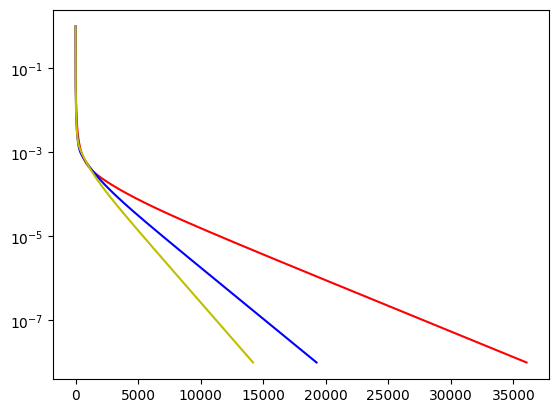

In [165]:
x0=np.zeros(A.shape[0]).reshape(n,1)
toll=1e-8
it_max=100000
omega=1.4  #valore per cui si ha il numero minimo di iterazioni.
solJac,itJac,err_vetJac=jacobi(A,b,x0,toll,it_max)
solGS,itGS,err_vetGS=gauss_seidel(A,b,x0,toll,it_max)
solGSor,itGSor,err_vetGSor=gauss_seidel_sor(A,b,x0,toll,it_max,omega)
# In analisi numerica il raggio spettrale viene utilizzato per determinare 
# se un metodo iterativo è convergente verso la soluzione di un problema. 
# È dimostrato infatti che un metodo iterativo per la risoluzione di un sistema 
# lineare (come il metodo di Jacobi o quello di Gauss-Seidel) converge alla 
# soluzione del sistema se e solo se il raggio spettrale della matrice di 
# iterazione è strettamente minore di 1.
print("Iterazioni Jac ",itJac)
print("Iterazioni GS ",itGS)
print("Iterazioni GS-SOR ",itGSor)

plt.semilogy(np.arange(itJac),err_vetJac, 'r-', np.arange(itGS),err_vetGS, 'b', np.arange(itGSor),err_vetGSor, 'y')

## Esercizio 2 
Si consideri il sistema lineare Ax=b, con A matrice e b termine noto memorizzati nel file ``testF.mat``.Risolvere il sistema utilizzando il metodo più adatto. Commentare i risultati ottenuti  giustificandoli alla luce della teoria. 

Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('testF.mat')``

``A=dati["A"] ``

`` b=dati["b"] ``

In [166]:
import scipy.linalg as spLin
dati = loadmat('testF.mat')
A1=dati["A"] 
b1=dati["b"]

In [167]:
m1,n1=A1.shape
print("Dimensione di A",m1,n1)

Dimensione di A 50 19


Si tratta di un sistema sovraderminato. Verifico se la matrice è a Rango massimo facendo uso della SVD e contando il numero di valori singolari diversi da zero.

In [168]:
 U,s,VT=spLin.svd(A1)  #Attenzione : Restituisce U, Sigma e VT=VTrasposta)
 thresh= np.spacing(1)*m*s[0] #m=max(m,n)
 k=np.count_nonzero(s>thresh) #Calcolo del rango della matrice, numero dei valori singolari diversi maggiori della soglia
 print("rango=",k)
 if k<n1 :
    print("La matrice non ha rango massimo")
 else:
    print("La matrice ha rango massimo")


rango= 15
La matrice non ha rango massimo


La matrice non è a rango massimo. Utilizzo il metodo SVD per risolvere il sistema sovradeterminato.

In [169]:
def SVDLS(A,b):
    n=A.shape[1]  # numero di colonne di A
    U,s,VT=spLin.svd(A)  #Attenzione : Restituisce U, Sigma e VT=VTrasposta)
    V=VT.T
     
    thresh=np.spacing(1)*m*s[0] 
    ##Calcolo del rango della matrice, numero dei valori singolari maggiori di una soglia
    k=np.count_nonzero(s>thresh)
    print("rango=",k)
    if k<n:
        print("La matrice non è a rango massimo")
    else:
        print("La matrice è a rango massimo")
    d=U.T@b
    d1=d[:k].reshape(k,1)
    s1=s[:k].reshape(k,1)
    #Risolve il sistema diagonale di dimensione kxk avene come matrice dei coefficienti la matrice Sigma
    c=d1/s1
    x=V[:,:k]@c 
    residuo=np.linalg.norm(d[k:])**2
    return x,residuo
     

In [170]:
x,residuo=SVDLS(A1,b1)
print("Soluzione nel senso dei minimi quadrati\n  ", x)
print("residuo ",residuo)
print("Norma soluzione ", np.linalg.norm(x))

rango= 15
La matrice non è a rango massimo
Soluzione nel senso dei minimi quadrati
   [[ 8.93308674e-01]
 [ 5.99593662e-02]
 [-1.00818890e-04]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.08594726e+00]
 [ 1.16319260e+00]
 [ 9.47694272e-01]
 [ 9.09857191e-01]]
residuo  8.36982653034658e-27
Norma soluzione  4.130358162106173


In [171]:
def qrLS(A,b):
    n=A.shape[1]  # numero di colonne di A
    Q,R=spLin.qr(A)
    h=Q.T@b
    x,flag=RS.Usolve(R[0:n,:],h[0:n])
    residuo=np.linalg.norm(h[n:])**2
    return x,residuo

In [172]:
def eqnorm(A,b):
 
    G=A.T@A
     
    print("Indice di condizionamento di G ",np.linalg.cond(G))
    f=A.T@b
    L=spLin.cholesky(G,lower=True)
   
    y,flag=RS.Lsolve(L,f)
    if flag==0:
        x,flag=RS.Usolve(L.T,y)
    
    
    return x

## Esercizio 3

Caricare dal  file  Approx_C.mat  le coppie di dati sperimentali (x(i),y(i)),i=1,M) e visto il trend dei dati, scegliere opportunamente  il grado del polinomio con cui approssimare  i dati. Costruirlo con un metodo di approssimazione nel senso dei minimi quadrati a scelta tra quello più opportuno alla luce della teoria, calcolare la norma 2 al quadrato del residuo e visualizzare  il grafico.


Rango  4 Condizionamento  138.04106498526866
residuo  28054.66293085903


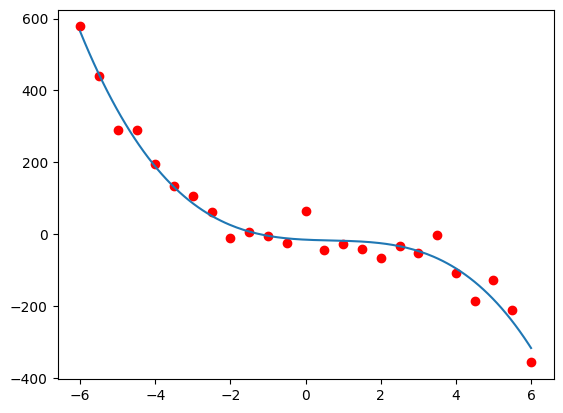

In [173]:
 import scipy.linalg as spLin
dati = loadmat('Approx_C.mat')

x=dati["x"]
y=dati["y"]
m=x.shape[0]
x=x.reshape(m,)
y=y.reshape(m,)
plt.plot(x,y,'ro')
 
#Visualizzando il trend dei dati osservo che hanno un andamento di un polinomio cubico
n=3
n1=n+1
A3=np.vander(x,increasing=True)[:,:n1]
print('Rango ' , np.linalg.matrix_rank(A3),'Condizionamento ',np.linalg.cond(A3))
#La matrice A è a rango massimo e mediamente mal condizionata,
#la matrice A^T A, avraà indice di condizionamento il quadrato dell'indice di condizionamento
#di A, per cui uso il metodo QR
alphaqr,res =qrLS(A3,y )
print("residuo ",res)
xx=np.linspace(np.min(x),np.max(x),200)
polQR=np.polyval(np.flip(alphaqr),xx)
plt.plot(xx,polQR)


## Esercizio 4


Siano assegnati i punti del piano di coordinate $(x_i, y_i)$, $i=1,\ldots,4$ con 
$$
\begin{array}{c}
x_1=0, \quad x_2=4, \quad x_3=0, \quad x_4=5\\
y_1=0, \quad y_2=0, \quad y_3=4, \quad y_4=6.
\end{array}
$$ 


 si costruisca il sistema lineare sovradeterminato ottenuto imponendo il passaggio della circonferenza di equazione $x^2+y^2+a_1x+a_2y+a_3=0$ per i quattro punti assegnati, e si denotino con ${\bf A}$ e ${\bf b}$ la matrice dei coefficienti e il termine noto ottenuti;

si sfrutti il metodo  più opportuno per ottenere la soluzione ${\bf a}^*$ del problema ai minimi quadrati $\min_{{\bf a} \in \mathbb{R}^3} \|{\bf A}{\bf a}-{\bf b}\|_2^2$;

si calcoli il valore di $\|{\bf A}{\bf a}^*-{\bf b}\|_2^2$ e, dopo averne determinato centro e raggio, si rappresentino in una stessa figura la circonferenza di equazione $x^2+y^2+a^*_1x+a^*_2y+a^*_3=0$ (individuata dalla soluzione ${\bf a}^*$ del problema ai minimi quadrati) e i quattro punti assegnati dal problema.

Si ricorda che data una circonferenza nella forma canonica
$$ x^2+y^2+a_1 x+a_2 x+a_3=0$$

le coordinate del suo centro sono 
$$C≡(-a_1/2,-a_2/2)$$

e la lunghezza del suo raggio è data da:

$$r=\sqrt{\frac{a_1^2}{4}+\frac{a_2^2}{4} -a_3}$$

e la circoferenza può essere rappresentata in forma parametrica $C(t),  t \in [0, 2 \cdot \pi]$ e le due componenti parametriche sono $$x(t)= C_0+r\cdot cos(t);$$ $$ y(t)= C_1+r\cdot sin(t)$$

rango= 3
La matrice è a rango massimo
Norma 2 al quadrato dell'errore  36.698412698412724


(-1.0609720865369214,
 6.681792039720546,
 -0.9948852973555004,
 6.748853551323754)

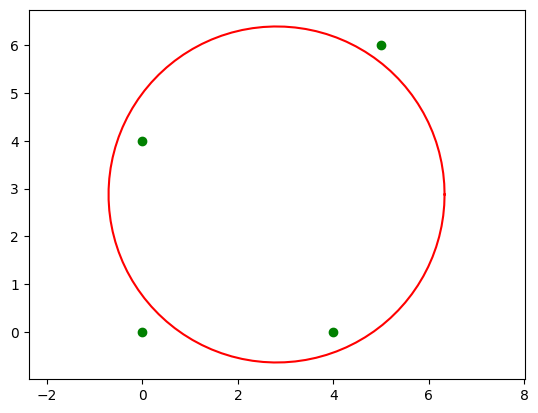

In [174]:
import math
px=np.array([0,4,0,5])
py=np.array([0,0,4,6])
#Costruisco il sistema lineare sovradeterminato come richiesto
A=np.array([[0,0,1],[4,0,1],[0,4,1],[5,6,1]])
b=np.array([[0],[-16],[-16],[-61]])
 
a,err=SVDLS(A,b)
print("Norma 2 al quadrato dell'errore ",err)
#Calcolo il centro
cx=-a[0]/2
cy=-a[1]/2
#Calcolo il raggio con la formula data
r1=math.sqrt((a[0]**2)/4+(a[1]**2)/4-a[2])
t=np.linspace(0,2*math.pi,100)
#Costruisco le due componenti parametriche della circonferemza
x=cx+r1*np.cos(t)
y=cy+r1*np.sin(t)
plt.plot(x,y,'r-')
plt.plot(px,py,'go')
plt.axis('equal')

## Esercizio 5

Per i dati $(x_i, y_i)$ riportati nei seguenti array

x = np.array([0.0004, 0.2507, 0.5008, 2.0007, 8.0013]) 

y = np.array([0.0007,0.0162, 0.0288, 0.0309, 0.0310])

- costruire la retta di regressione;
- costruire la parabola approssimante i dati nel senso dei minimi quadrati;
- determinare l'approssimazione ai minimi quadrati espressa in termini di
basi esponenziali: $y = a + b e^{-x}+ c e^{-2x}$

Quale tra le tre approssimazioni risulta la migliore? (Confrontare i gra
ci e la norma euclidea al quadrato del vettore dei residui).

In [175]:
m=5
x4 = np.array([0.0004, 0.2507, 0.5008, 2.0007, 8.0013]) 
y4 = np.array([0.0007,0.0162, 0.0288, 0.0309, 0.0310]) 
M=np.zeros((5,3))
M[:,0]=np.ones((5,))
M[:,1]=np.exp(-x4)
M[:,2]=np.exp(-2*x4)

In [176]:
print('Rango di ---->' , np.linalg.matrix_rank(M))
print("Con Condizionamento M --> ",np.linalg.cond(M))
#La matrice M è a rango massimo, ha condizionamento 18.45, quindi la marice G delle equazioni
#normali (di dimensioni 4x4) avrebbe indice
#di condizionamento circa 343. Utilizzo il metodo 
aexp,resexp=qrLS(M,y4)


Rango di ----> 3
Con Condizionamento M -->  18.45808953019451


Rango di A1 ---> 2
Condizionamento di A1--->  4.663457775986456
Indice di condizionamento di G  21.747838428408542
Rango di A2 3
Condizionamento di A2  65.67493525624785
quadrato residuo exp 1.2249733128901832e-05
quadrato residuo pol grado 2  0.00023646355940249873


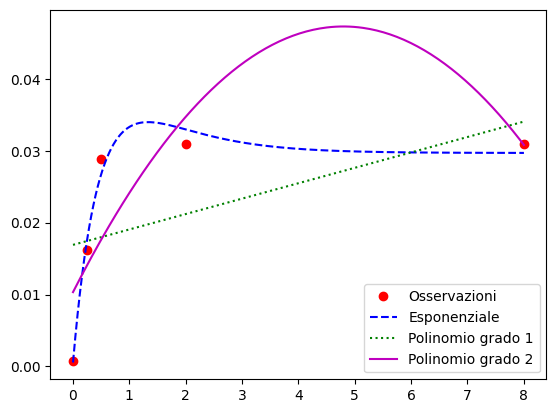

In [177]:
xx=np.linspace(np.min(x4),np.max(x4),200)
polexp=aexp[0]+aexp[1]*np.exp(-xx)+aexp[2]*np.exp(-2*xx)

# Calcolo del polinomio approssimante di grado 1
n=1
n1=n+1
A1=np.vander(x4,increasing=True)[:,:n1]
print('Rango di A1 --->',np.linalg.matrix_rank(A1))
print("Condizionamento di A1---> ",np.linalg.cond(A1))
#Matrice a rango massimo e ben condizionata: uso le equazioni normali
alpha1=eqnorm(A1,y4)
pol1=np.polyval(np.flip(alpha1),xx)

#Parabola approssimante
n=2
n1=n+1
A2=np.vander(x4,increasing=True)[:,:n1]
print('Rango di A2',np.linalg.matrix_rank(A2))
print("Condizionamento di A2 ",np.linalg.cond(A2))
#Matrice a rango massimo e mediamente mal condizionata: uso qr
alpha2,res2=qrLS(A2,y4)
pol2=np.polyval(np.flip(alpha2),xx)
print("quadrato residuo exp",resexp)
print("quadrato residuo pol grado 2 ",res2)

plt.plot(x4,y4,'ro',xx,polexp,'b--',xx,pol1,'g:',xx,pol2,'m-')
plt.legend(['Osservazioni','Esponenziale','Polinomio grado 1','Polinomio grado 2'])